### IS Proof of concept
Finding Product position on Social Network (PPSN)

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import itertools
import math
import string
import json
import pymongo

In [2]:
import time
from datetime import datetime
today = datetime.now()

In [3]:
#!pip install pythainlp
import pythainlp
from pythainlp import Tokenizer
from pythainlp.util import normalize
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus.common import thai_words
from pythainlp import sent_tokenize
from pythainlp.corpus import thai_stopwords
from pythainlp.util import dict_trie
from pythainlp.tag import pos_tag

In [4]:
import statistics as stat
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# https://thainlp.org/pythainlp/docs/2.0/api/tag.html
from pythainlp.spell import correct
from pythainlp.tag import pos_tag

#https://thainlp.org/pythainlp/docs/2.0/api/transliterate.html
from pythainlp.transliterate import romanize

In [6]:
from bs4 import BeautifulSoup
from urllib.request import urlopen

In [7]:
from IPython.display import clear_output

In [8]:
# Files definition
root_path = 'Datasource'

comment_file = []
comment_file.append(root_path+"/comment_meiji.csv")
comment_file.append(root_path+"/comment_DDCF.csv")

#comment_file = []
#comment_file.append("comment_meiji.csv")
#comment_file.append("comment_DDCF.csv")

comment_nlp_file = root_path+"/comment_nlpToken.csv"
comment_cooc_nlp_file = root_path+"/comment_cooc.xlsx"

#comment_nlp_file = "comment_nlpToken.csv"
#comment_cooc_nlp_file = "comment_cooc.xlsx"

In [9]:
# Connect MongoDB
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["NIDA_PPSN"]
mycol = mydb["NIDA_PPSN_THREAD"]
ppsn_w = mydb["NIDA_PPSN_WORD"]

eda_w_th = mydb["NIDA_PPSN_EDA_W_TH"]
eda_w_en = mydb["NIDA_PPSN_EDA_W_EN"]

In [10]:
def checkPunc(wtkn):
    newList,cnt = [],0
    for word in wtkn:
        for char in word:
            if char in set(string.punctuation):
                cnt = cnt + 1
        if cnt == 0:
            newList.append(word)
        cnt = 0
    return newList

In [11]:
def checkStopwords(w):
    returnList = []
    stopwords = set(thai_stopwords())
    for i in w:  # comment
        if i not in stopwords:
            returnList.append(i)
    return returnList

In [12]:
def checkThai(txt):
    prop = pythainlp.util.countthai(txt)
    return prop

In [13]:
def normThai(w):
    returnList = []
    for i in w:
        returnList.append(normalize(i))
    return returnList

In [14]:
def tagThai(w):
    pd_returnList = pd.DataFrame(pos_tag(w, corpus='pud'))
    returnList = pd_returnList.iloc[:,1]
    return returnList

In [15]:
def soundThai(w):
    returnList = []
    for i in w:
        returnList.append(romanize(i, engine="thai2rom"))
    return returnList

### Clean data & NLP Tokenized

## ตัดคำแบบไม่ Train corpus/term และเก็บลง MongoDB

https://www.thainlp.org/pythainlp/tutorials/notebooks/pythainlp-get-started.html#Thai-Characters

เก็บข้อมูลลง MongoDB

### ===== EDA Part =====
สรุป Term frequency ของคำ ราย Overall & URL<br>
<b>ขั้นตอนนี้มีความสำคัญ เพราะเราจะเลือกคำนามที่มีความถี่สูง 1000 คำ มาทำ Bag of word และ Factor Analysis</b>

2.EDA คำรายกระทู้ การกล่าวถึงแบรนด์ในแต่ละกระทู้ และสรุป Term ที่ใช้ Train ตอนตัดคำ<br>
ทั้งนี้จะนำ thai_word() มาตัดคำให้เหลือแต่คำที่มีความหมายเท่านั้น หลังจากสรุป Freq รอบแรก และดู Freq หลังตัดอีกครั้ง

EDA Characteristic approach (Descriptive)
1. MAX คำต่อกระทู้
2. MIN คำต่อกระทู้
3. AVG คำต่อกระทู้
4. กราฟการกระจายคำต่อกระทู้
5. จำนวนกระทู้
6. พบ brand 5 ตัว ตัวละกี่กระทู้
7. กระทู้ที่มีคำเปรียบเทียบ มีกี่กระทู้
8. Term frequency

เพิ่ม commentId
8. comment มี 1 brand
9. comment มี 2 brand

In [16]:
cursor2 = mydb.NIDA_PPSN_WORD.find()

In [17]:
df_EDA_frq = pd.DataFrame(cursor2)

In [18]:
df_EDA_frq.tail(3)

,URLs,WORD,_id,commentId,token_sound,token_tag
1659115,https://pantip.com/topic/30651064,ข้อความ,5fa4c53b6e14c94326b53f86,66186,khokhwam,NOUN
1659116,https://pantip.com/topic/30651064,กันยายน,5fa4c53b6e14c94326b53f87,66186,kanyayon,NOUN
1659117,https://pantip.com/topic/30651064,เวลา,5fa4c53b6e14c94326b53f88,66186,wela,NOUN


In [67]:
print('จำนวนกระทู้ = ',len(df_EDA_frq.URLs.unique()))
print('จำนวนคำต่อกระทู้มากที่สุด = ',max(df_EDA_frq.URLs.value_counts()))
print('จำนวนคำต่อกระทู้น้อยที่สุด = ',min(df_EDA_frq.URLs.value_counts()))
print('จำนวนคำต่อกระทู้เฉลี่ย = ', str(round(stat.mean(df_EDA_frq.URLs.value_counts()), 2)))

จำนวนกระทู้ =  1514
จำนวนคำต่อกระทู้มากที่สุด =  24365
จำนวนคำต่อกระทู้น้อยที่สุด =  11
จำนวนคำต่อกระทู้เฉลี่ย =  1095.85


In [68]:
print('จำนวนคำต่อ comment มากที่สุด = ',max(df_EDA_frq.commentId.value_counts()))
print('จำนวนคำต่อ comment น้อยที่สุด = ',min(df_EDA_frq.commentId.value_counts()))
print('จำนวนคำต่อ comment เฉลี่ย = ', str(round(stat.mean(df_EDA_frq.commentId.value_counts()), 2)))

จำนวนคำต่อ comment มากที่สุด =  1492
จำนวนคำต่อ comment น้อยที่สุด =  1
จำนวนคำต่อ comment เฉลี่ย =  27.57


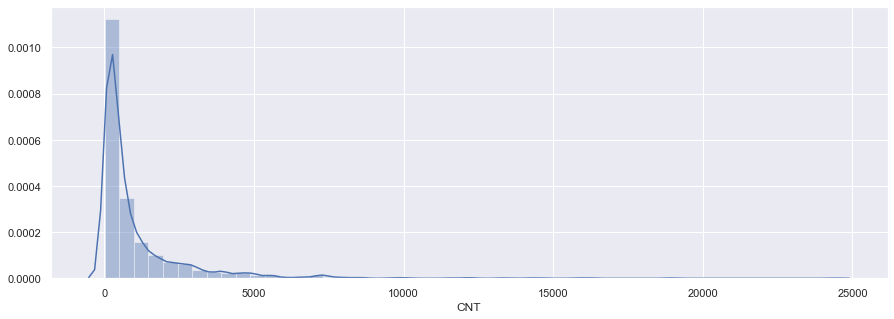

In [69]:
df_plot_dist = pd.DataFrame(df_EDA_frq.URLs.value_counts())
df_plot_dist.columns = ['CNT']
sns.set(style="darkgrid")  
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.distplot(df_plot_dist.CNT, kde=True)
plt.show()

จากข้อมูลการกล่าวถึง พบว่าจำนวนนั้น imbalance กัน แต่เนื่องจากเราไม่ได้จะทำโมเดลทำนาย จึงไม่ต้อง Over-Undersample<br>
เราทำกราฟ จะต้อง normalized ตัวเลขในตาราง Cooccurence ด้วยค่า Lift ก่อน<br>

และเราพบว่าการตัดข้อความชื่อนม ฟาร์มโชคชัย มีปัญหา พบว่าจะเจอคำว่า อืมม มิลค์ (Umm) มากกว่าชื่อแบรนด์ตรงๆ

In [70]:
print('การกล่าวถึง เมจิ :',len(df_EDA_frq[df_EDA_frq.WORD.isin(['เมจิ','meiji','cpmeiji'])].URLs.unique()),'กระทู้')
print('การกล่าวถึง โชคชัย :',len(df_EDA_frq[df_EDA_frq.WORD.isin(['โชคชัย','chokchai','ฟาร์มโชคชัย','อืมม','umm'])].URLs.unique()),'กระทู้')
print('การกล่าวถึง ดัชมิลล์ :',len(df_EDA_frq[df_EDA_frq.WORD.isin(['ดัชมิลล์','ดัชมิล','dutchmill','dutchmilk','ดัชชี่','นมดัช'])].URLs.unique()),'กระทู้')
print('การกล่าวถึง เอ็มมิลค์ :',len(df_EDA_frq[df_EDA_frq.WORD.isin(['เอ็มมิลค์','mmilk','เอ็มมิ้ลค์'])].URLs.unique()),'กระทู้')
print('การกล่าวถึง โฟร์โมสต์ :',len(df_EDA_frq[df_EDA_frq.WORD.isin(['โฟร์โมสต์','โฟร์โมส','foremost','นมโฟ'])].URLs.unique()),'กระทู้')
print('การกล่าวถึง แดรี่โฮม :',len(df_EDA_frq[df_EDA_frq.WORD.isin(['แดรี่โฮม','แดรี่','โฮม','dairy','dairy home'])].URLs.unique()),'กระทู้')

การกล่าวถึง เมจิ : 1008 กระทู้
การกล่าวถึง โชคชัย : 28 กระทู้
การกล่าวถึง ดัชมิลล์ : 251 กระทู้
การกล่าวถึง เอ็มมิลค์ : 2 กระทู้
การกล่าวถึง โฟร์โมสต์ : 288 กระทู้
การกล่าวถึง แดรี่โฮม : 106 กระทู้


## ตัดคำแบบ Train

## สร้าง Bag of word dataframe
ไม่มีทางเลือก Review Lit มาแล้ว ต้องคัดคำระดับ 1000 คำ มาทำ รันไปเลย 4-6 ชั่วโมง รันจบแล้วถึงทำ  Factor Analysis/T-SNE ต่อ<br>
ให้คัดเลือก flavor, brand, market clean ตาม term ให้ครบ นอกนั้นให้ดึงมาทั้งหมดตรงๆ

1. ตัดคำ และ Process คำ รอบที่ 2
2. Clean คำ ชื่อ Flavor และชื่อ Brand
3. นับคำในแต่ละเอกสาร (Comment)
4. รอ รอ รอ

In [ ]:
cursor3 = mydb.NIDA_PPSN_WORD.find()

In [ ]:
df_bow = pd.DataFrame(cursor3)

### Create co-occurrence matrix จาก Bag of word

In [ ]:
item_item_matrix = pd.DataFrame(index=join_df.columns,columns=join_df.columns).fillna(0)

In [ ]:
def cnt_Grpby(df,i,j):
    PAIB = pd.DataFrame(df.groupby(df.iloc[:,i].name)[df.iloc[:,j].name].value_counts())
    PAIB.index.names = ['A','B']
    PAIB.columns = ['freq']
    PAIB.reset_index(inplace=True)
    _PAIB = PAIB[(PAIB.A>0)&(PAIB.B>0)]
    return _PAIB.freq.sum()

In [ ]:
# Co-occurrence
for i in range(0,len(item_item_matrix.columns)):
    for j in range(0,len(item_item_matrix.columns)):
        if i != j:
            item_item_matrix.iloc[i,j] = cnt_Grpby(join_df,i,j)
        else:
            item_item_matrix.iloc[i,j] = 0

In [ ]:
item_item_matrix.head()

In [ ]:
item_item_matrix.to_excel(comment_past_nlp_file, index=True)

### Create co-occurrence matrix with Lift normalization

In [ ]:
item_item_matrix = pd.DataFrame(index=join_df.columns,columns=join_df.columns).fillna(0)

In [ ]:
def a_in_b(df,i,j):
    PAIB = pd.DataFrame(df.groupby(df.iloc[:,j].name)[df.iloc[:,i].name].value_counts())
    PAIB.index.names = ['B','A']
    PAIB.columns = ['freq']
    PAIB.reset_index(inplace=True)
    PAIB_ = PAIB[(PAIB.A>0)&(PAIB.B>0)]
    return PAIB_.freq.sum()/PAIB.freq.sum()

In [ ]:
for i in range(0,len(item_item_matrix.columns)) :
    for j in range(0,len(item_item_matrix.columns)) :
        A = join_df.iloc[:,i]
        B = join_df.iloc[:,j]
        PA = A[A!=0].count()/A.shape[0]
        PB = B[B!=0].count()/B.shape[0]
        PAB = PB*a_in_b(join_df,i,j)
        item_item_matrix.iloc[i,j] = PAB/(PA*PB)

In [ ]:
item_item_matrix.replace([np.inf, -np.inf], np.nan,inplace=True)
item_item_matrix.fillna(0,inplace=True)

In [ ]:
item_item_matrix.head()

In [ ]:
item_item_matrix.to_excel(comment_past_nlp_file, index=True)